In [62]:
import tensorflow as tf
import json
import os

from core.data  import pretraining_records
from core.astromer import get_ASTROMER, train

import matplotlib.pyplot as plt
# from matplotlib import rc
# rc('text', usetex=True)

# plt.style.use('dark_background')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
exp_path = './runs/macho_old_pe'

In [64]:
conf_file = os.path.join(exp_path, 'conf.json')

with open(conf_file, 'r') as handle:
    conf = json.load(handle)
conf

{'max_obs': 50,
 'data': './data/records/macho3/',
 'p': './runs/macho_old_pe/',
 'batch_size': 256,
 'epochs': 3000,
 'patience': 2000,
 'finetuning': False,
 'repeat': 1,
 'layers': 1,
 'heads': 2,
 'head_dim': 106,
 'dff': 512,
 'dropout': 0.1,
 'base': 1000,
 'lr': 0.001}

In [30]:
test_batches = pretraining_records(os.path.join('./data/records/macho2', 'test'), 
                            conf['batch_size'], 
                            max_obs=conf['max_obs'])

sum([1 for x in test_batches.unbatch()])

93924

In [31]:
astromer = get_ASTROMER(num_layers=conf['layers'],
                        d_model=conf['head_dim'],
                        num_heads=conf['heads'],
                        dff=conf['dff'],
                        base=conf['base'],
                        dropout=conf['dropout'],
                        maxlen=conf['max_obs'])

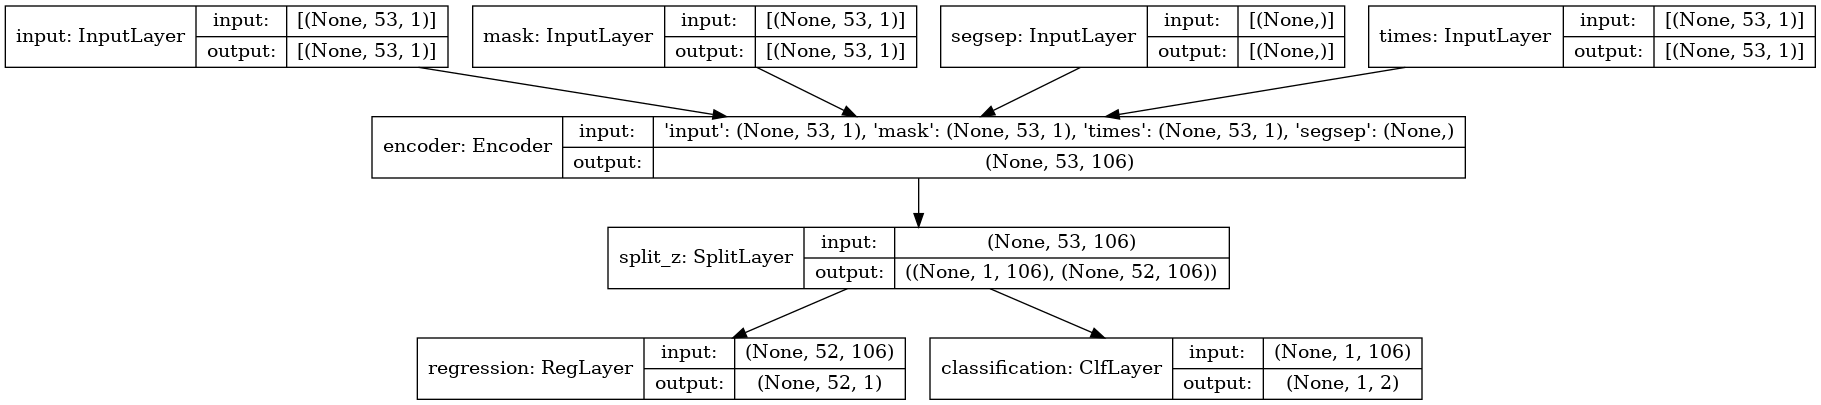

In [32]:
tf.keras.utils.plot_model(astromer, show_shapes=True)

In [33]:
weights_path = '{}/weights'.format(conf['p'])
astromer.load_weights(weights_path)

In [34]:
from core.astromer import predict

In [35]:
result = predict(astromer, test_batches, conf)
result['acc']

prediction: 0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['label'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])
prediction: 367it [01:11,  5.13it/s]


0.98737127

In [36]:
result['mse']

4.0932493e-05

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


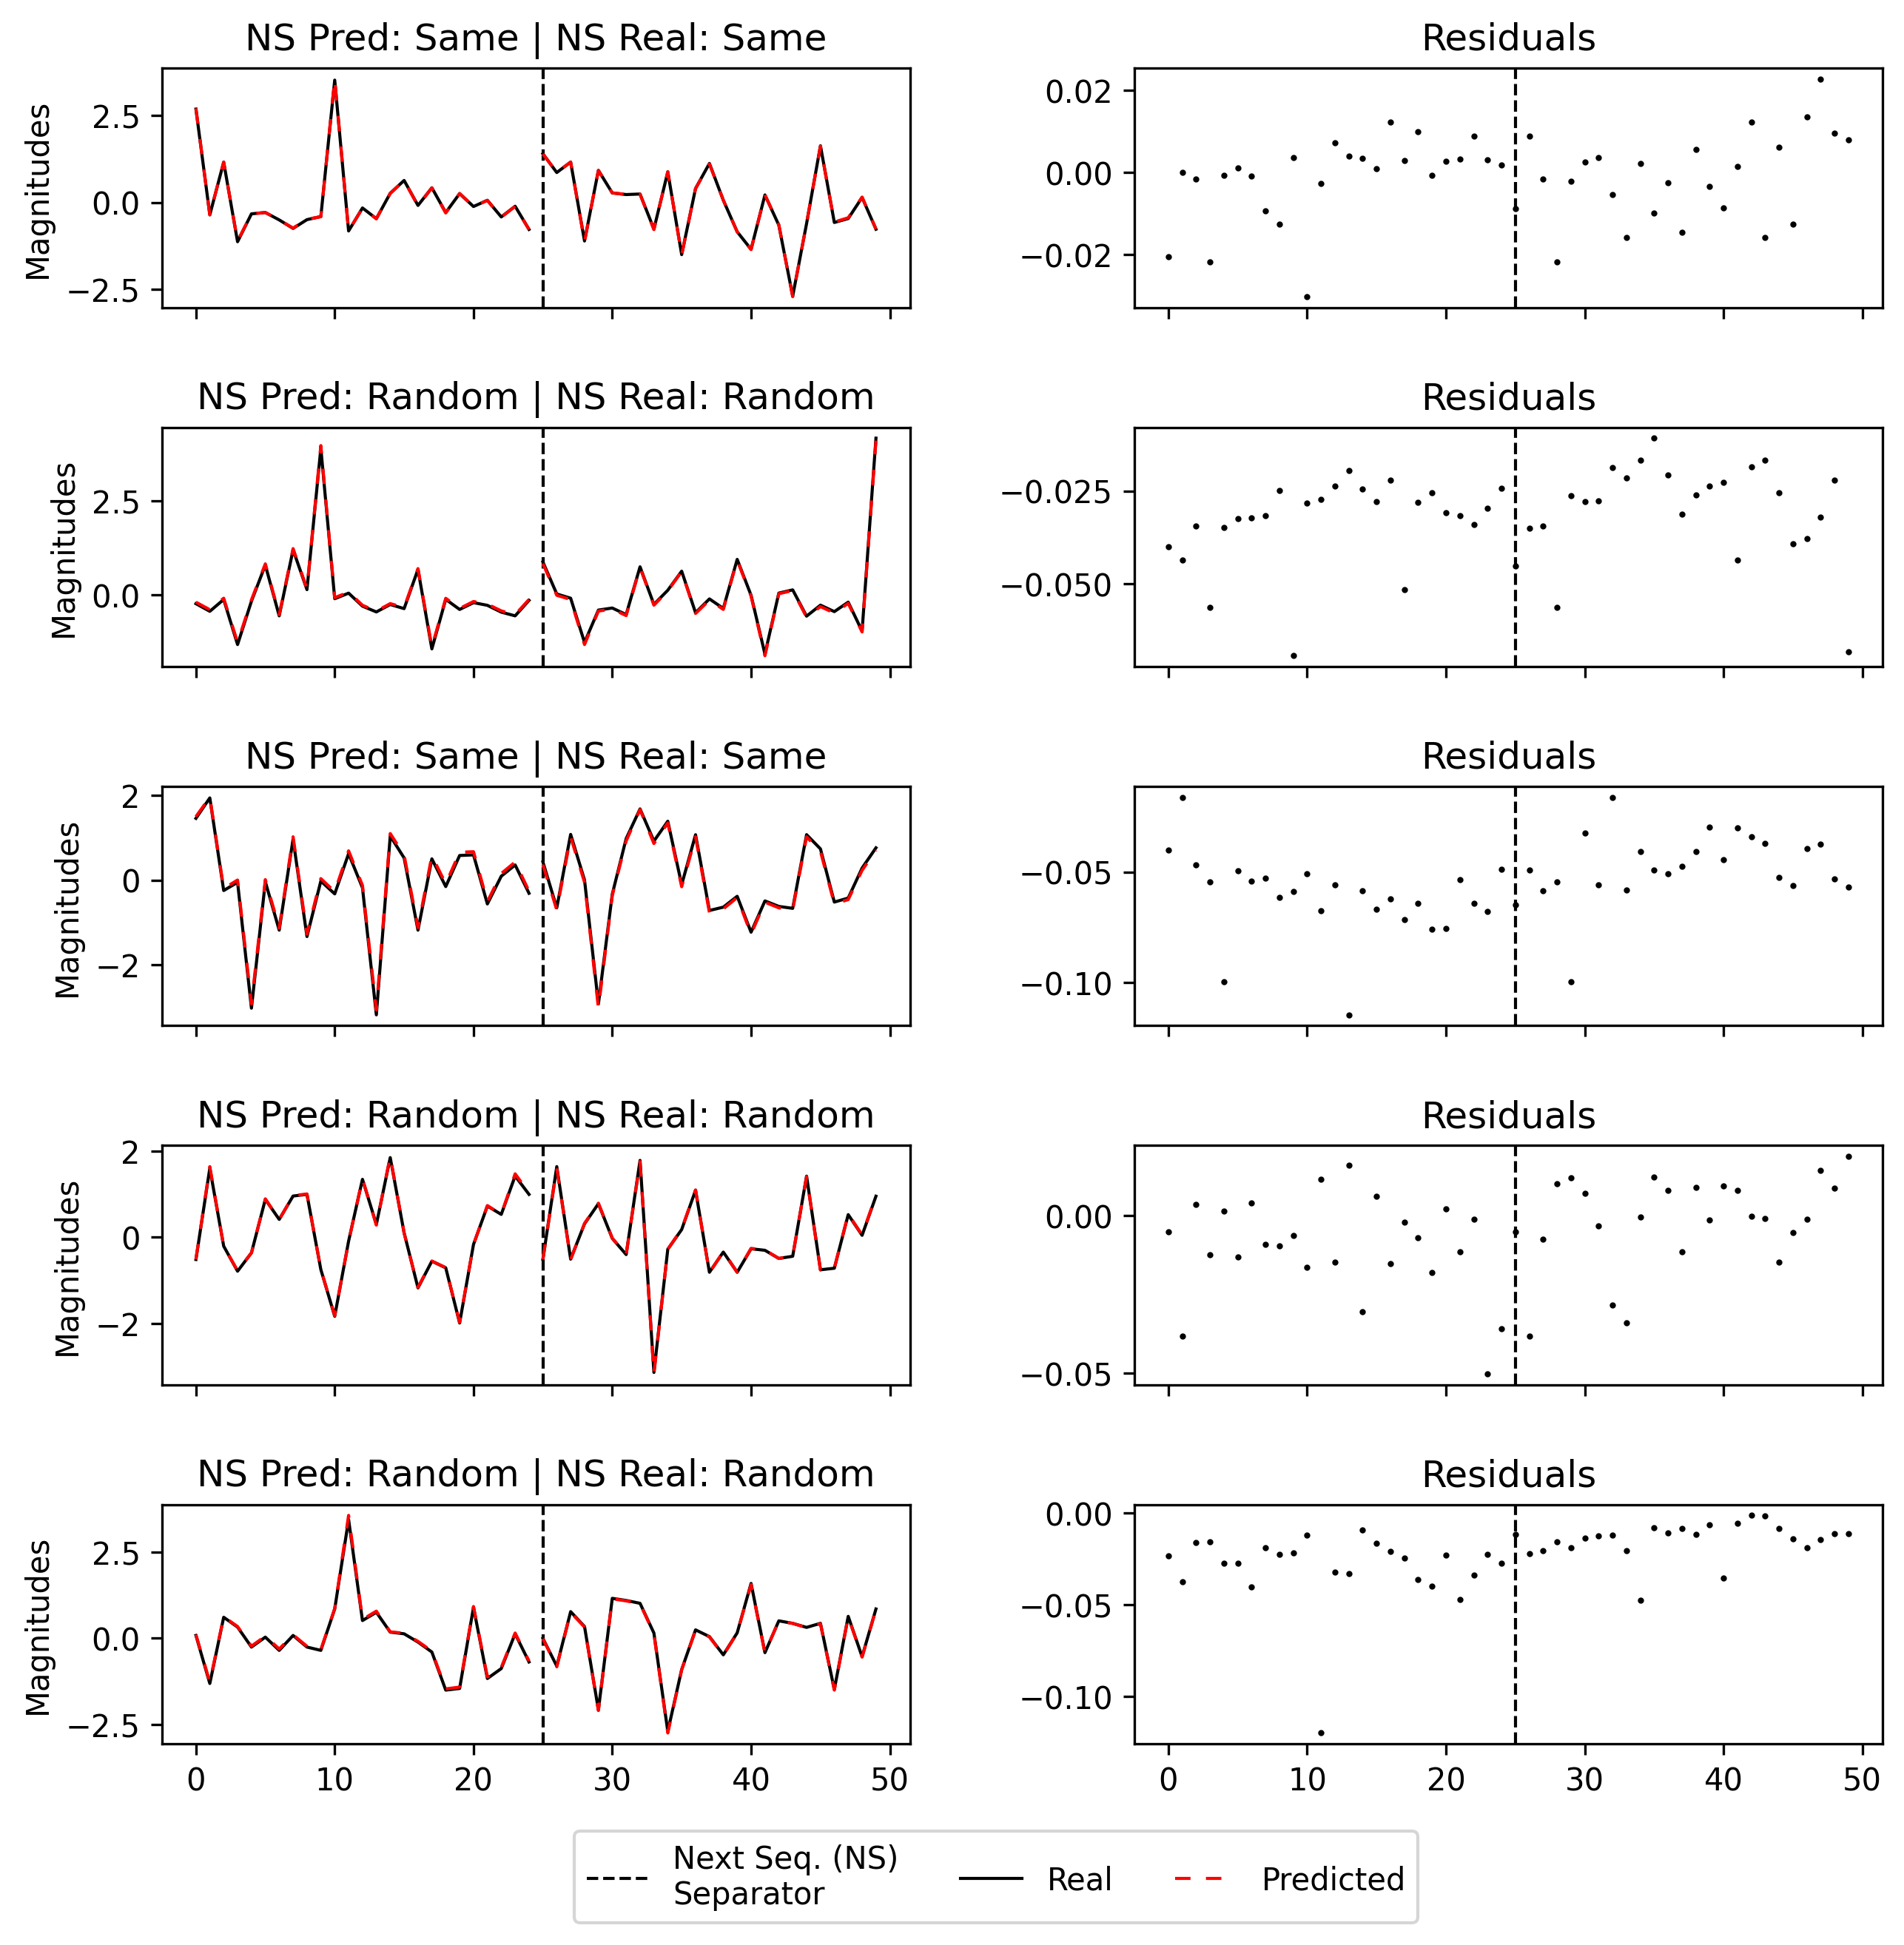

In [37]:
N = 5
fig, axes = plt.subplots(N, 2, dpi=300, figsize=(10,10),
                         gridspec_kw={'hspace': 0.5, 'wspace': 0.3},
                         sharey=False, sharex=True)

obs = conf['max_obs']//2

for i in range(N):

    times_prev = range(0, obs)
    times_post = range(obs, conf['max_obs'])
    

    serie_1_pred = result['x_true'][i][1:obs+1]
    serie_1_true = result['x_pred'][i][:obs]

    residual_1 = serie_1_pred - serie_1_true

    serie_2_pred = result['x_true'][i][obs+2:-1]
    serie_2_true = result['x_pred'][i][obs+1:-1]

    residual_2 = serie_2_pred - serie_2_true
    
    axes[i][0].axvline(x=obs, color='k', linewidth=1, linestyle='--', label='Next Seq. (NS)\nSeparator')

    axes[i][0].plot(times_prev, serie_1_pred, marker='',linewidth=1, linestyle='-', color='k')
    axes[i][0].plot(times_prev, serie_1_true, marker='',linewidth=1, linestyle='--', color='red', dashes=(5, 5))
    
    axes[i][0].plot(times_post, serie_2_true, marker='',linewidth=1, linestyle='-', color='k', label='Real')
    axes[i][0].plot(times_post, serie_2_pred, marker='',linewidth=1, linestyle='--', color='red', dashes=(5, 5),label='Predicted')
    

    axes[i][1].plot(times_prev, residual_1, '.', markersize=2, color='k')
    axes[i][1].plot(times_post, residual_2, '.', markersize=2, color='k')
    axes[i][1].axvline(x=obs, color='k', linewidth=1, linestyle='--')
    axes[i][1].set_title('Residuals')
    
    
    npp_lab_pred = 'Random' if result['y_pred'][i] == 1 else 'Same'
    npp_lab_true = 'Random' if result['y_true'][i] == 1 else 'Same'
    axes[i][0].set_title(r"NS Pred: "+npp_lab_pred+" | "+r"NS Real: "+npp_lab_true)

    axes[i][0].set_ylabel('Magnitudes')
    
axes[-1][0].legend(ncol=3, bbox_to_anchor = (1.7, -0.3))
fig.tight_layout()

## Learning Curves

In [38]:
import tensorflow as tf
import numpy as np
from tensorflow.core.util import event_pb2
from tensorflow.python.lib.io import tf_record
from tensorboard.backend.event_processing import event_accumulator

def my_summary_iterator(path):
    for r in tf_record.tf_record_iterator(path):
        yield event_pb2.Event.FromString(r)

def get_metrics(path_logs):
    train_logs = [x for x in os.listdir(path_logs) if x.endswith('.v2')][0]
    path_train = os.path.join(path_logs, train_logs)

    ea = event_accumulator.EventAccumulator(path_train)
    ea.Reload()

    metrics = {tag:[] for tag in ea.Tags()['tensors']}
    for e in my_summary_iterator(path_train):
        for v in e.summary.value:
            if v.tag == 'model': continue
            value = tf.make_ndarray(v.tensor)
            metrics[v.tag].append(value)
    return metrics

In [39]:
pathexp = conf['p']
train_metrics = get_metrics(os.path.join(pathexp, 'logs', 'train'))
val_metrics = get_metrics(os.path.join(pathexp, 'logs', 'valid'))

Text(0.52, 0.05, 'Number of Epochs')

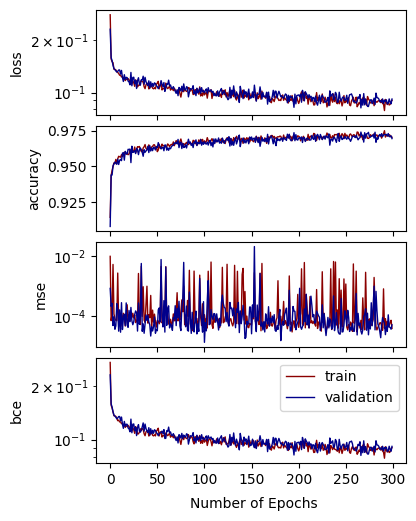

In [59]:
fig, axes = plt.subplots(4, 1, figsize=(4,6), sharex=True, gridspec_kw={'hspace': 0.1, 'wspace': 0.3}, dpi=100)
for i, key in enumerate(val_metrics.keys()):
    
    train_values = np.array(train_metrics[key])
    train_values = train_values[np.arange(0, len(train_values), 10)]
    vaild_values = np.array(val_metrics[key])
    vaild_values = vaild_values[np.arange(0, len(vaild_values), 10)]
    
    axes[i].plot(train_values, label='train', color='darkred', linewidth=1)
    axes[i].plot(vaild_values, label='validation', color='darkblue', linewidth=1)
    axes[i].set_ylabel(key)
    if key != 'accuracy':
        axes[i].set_yscale('log')
axes[-1].legend(loc='upper right')
fig.text(0.52, 0.05, 'Number of Epochs', ha='center')

## Finetuning

In [66]:
conf_file = os.path.join(conf['p'], 'finetuning', 'model_1','conf.json')

with open(conf_file, 'r') as handle:
    conf_ft = json.load(handle)
conf_ft

{'max_obs': 50,
 'data': './data/records/macho3/',
 'p': './runs/macho_old_pe/finetuning/model_1',
 'batch_size': 256,
 'epochs': 3000,
 'patience': 2000,
 'finetuning': False,
 'repeat': 1,
 'layers': 1,
 'heads': 2,
 'head_dim': 106,
 'dff': 512,
 'dropout': 0.1,
 'base': 1000,
 'lr': 0.001}

In [49]:
test_batches_ft = pretraining_records(os.path.join('./data/records/macho3', 'test'), 
                            conf_ft['batch_size'], 
                            max_obs=conf_ft['max_obs'])

sum([1 for x in test_batches.unbatch()])

10404

In [50]:
ft_model = get_ASTROMER(num_layers=conf_ft['layers'],
                        d_model=conf_ft['head_dim'],
                        num_heads=conf_ft['heads'],
                        dff=conf_ft['dff'],
                        base=conf_ft['base'],
                        dropout=conf_ft['dropout'],
                        maxlen=conf_ft['max_obs'])

In [52]:
weights_path = '{}/weights'.format(conf['p'])
ft_model.load_weights(weights_path)

In [53]:
result = predict(ft_model, test_batches_ft, conf_ft)

prediction: 0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['label'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])
prediction: 41it [00:05,  7.17it/s]


0.9704603

In [61]:
print(result['acc'], result['mse'])

0.9704603 7.367327e-05


In [56]:
train_metrics = get_metrics(os.path.join(conf_ft['p'], 'logs', 'train'))
val_metrics = get_metrics(os.path.join(conf_ft['p'], 'logs', 'valid'))

Text(0.52, 0.05, 'Number of Epochs')

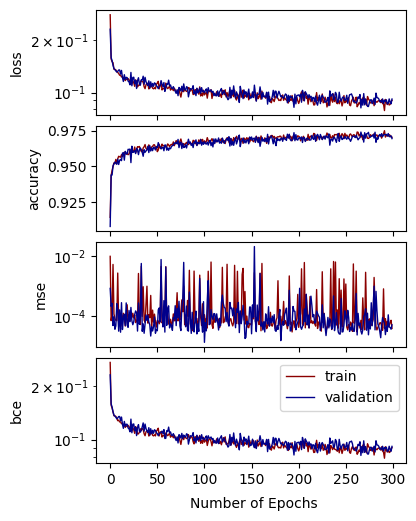

In [60]:
fig, axes = plt.subplots(4, 1, figsize=(4,6), sharex=True, gridspec_kw={'hspace': 0.1, 'wspace': 0.3}, dpi=100)
for i, key in enumerate(val_metrics.keys()):
    
    train_values = np.array(train_metrics[key])
    train_values = train_values[np.arange(0, len(train_values), 10)]
    vaild_values = np.array(val_metrics[key])
    vaild_values = vaild_values[np.arange(0, len(vaild_values), 10)]
    
    axes[i].plot(train_values, label='train', color='darkred', linewidth=1)
    axes[i].plot(vaild_values, label='validation', color='darkblue', linewidth=1)
    axes[i].set_ylabel(key)
    if key != 'accuracy':
        axes[i].set_yscale('log')
axes[-1].legend(loc='upper right')
fig.text(0.52, 0.05, 'Number of Epochs', ha='center')

## Special Task: Classification

In [83]:
from core.astromer_clf import get_CLASSIFIER, predict

In [84]:
conf_file = os.path.join(conf['p'], 'finetuning', 'model_1','classification','rnn_0','conf.json')

with open(conf_file, 'r') as handle:
    conf_rnn = json.load(handle)
conf_rnn

{'max_obs': 50,
 'data': './data/records/macho3/',
 'batch_size': 256,
 'epochs': 4000,
 'patience': 2000,
 'take': 1,
 'astromer': './runs/macho_old_pe/finetuning/model_1/',
 'units': 64,
 'dropout': 0.2,
 'lr': 0.001,
 'p': './runs/macho_old_pe/finetuning/model_1/classification/rnn_0'}

In [92]:
test_batches_rnn = pretraining_records(os.path.join('./data/records/macho3', 'val'), 
                            conf_rnn['batch_size'], 
                            max_obs=conf_rnn['max_obs'])

sum([1 for x in test_batches.unbatch()])

10404

In [93]:
clf_model = get_CLASSIFIER(ft_model, conf_rnn['units'], conf_rnn['dropout'], 2)

In [94]:
weights_path = '{}/weights'.format(conf_rnn['p'])
clf_model.load_weights(weights_path)

In [95]:
result = predict(clf_model, test_batches_rnn, conf_rnn)

prediction: 41it [00:06,  5.92it/s]


In [100]:
print(result['acc'], result['bce'])

0.6830157 1.6338563


In [105]:
def get_metrics(path_logs):
    train_logs = [x for x in os.listdir(path_logs) if x.endswith('.v2')][0]
    path_train = os.path.join(path_logs, train_logs)

    ea = event_accumulator.EventAccumulator(path_train)
    ea.Reload()

    print(ea.Tags())
    metrics = {tag:[] for tag in ea.Tags()['tensors']}
    
    for e in my_summary_iterator(path_train):
        for v in e.summary.value:
            if v.tag == 'model': continue
            value = tf.make_ndarray(v.tensor)
            metrics[v.tag].append(value)
    return metrics

In [106]:
train_metrics = get_metrics(os.path.join(conf_rnn['p'], 'logs', 'train'))
val_metrics = get_metrics(os.path.join(conf_rnn['p'], 'logs', 'valid'))

{'images': [], 'audio': [], 'histograms': [], 'scalars': [], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}
{'images': [], 'audio': [], 'histograms': [], 'scalars': [], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}


In [104]:
train_metrics

{}

No handles with labels found to put in legend.


Text(0.52, 0.05, 'Number of Epochs')

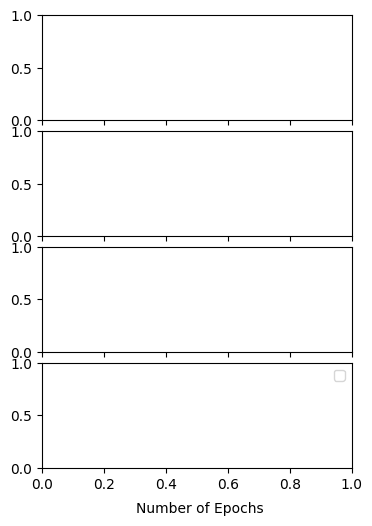

In [99]:
fig, axes = plt.subplots(4, 1, figsize=(4,6), sharex=True, gridspec_kw={'hspace': 0.1, 'wspace': 0.3}, dpi=100)
for i, key in enumerate(val_metrics.keys()):
    
    train_values = np.array(train_metrics[key])
    train_values = train_values[np.arange(0, len(train_values), 10)]
    vaild_values = np.array(val_metrics[key])
    vaild_values = vaild_values[np.arange(0, len(vaild_values), 10)]
    
    axes[i].plot(train_values, label='train', color='darkred', linewidth=1)
    axes[i].plot(vaild_values, label='validation', color='darkblue', linewidth=1)
    axes[i].set_ylabel(key)
    if key != 'accuracy':
        axes[i].set_yscale('log')
axes[-1].legend(loc='upper right')
fig.text(0.52, 0.05, 'Number of Epochs', ha='center')